# Web scraping

In [1]:
# On utilise l'API Wikipedia pour parcourir Wikipedia
!pip install wikipedia-api

  Created wheel for wikipedia-api: filename=Wikipedia_API-0.5.4-cp37-none-any.whl size=13462 sha256=b54bdaf849ee9298f7c14ed91bd85e4271210e44738e0827743a5f743e4a9c98
  Stored in directory: /root/.cache/pip/wheels/bf/40/42/ba1d497f3712281b659dd65b566fc868035c859239571a725a
Successfully built wikipedia-api


In [2]:
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm

def wiki_page(page_name):
    wiki_api = wikipediaapi.Wikipedia(language='fr',
            extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(page_name)
    if not page_name.exists():
        print('Page {} does not exist.'.format(page_name))
        return

    page_data = pd.DataFrame({
        'page': page_name,
        'text': page_name.text,
        'link': page_name.fullurl,
        'categories': [[y[9:] for y in
                       list(page_name.categories.keys())]],
        })

    return page_data

In [ ]:
# this data will be used for training
data = wiki_page('Paris')

data.head()

,page,text,link,categories
0,"Paris (id: 681159, ns: 0)",Paris ([pa.ʁi]) est la commune la plus peuplée...,https://fr.wikipedia.org/wiki/Paris,"[:Aire urbaine de Paris, :Ancien chef-lieu de ..."


In [3]:
# this data will be used for test
data_test = wiki_page('Rome')
data_test.head()

,page,text,link,categories
0,"Rome (id: 3324146, ns: 0)",Rome (/ʁɔm/ ; en italien : Roma /ˈroːma/ ) es...,https://fr.wikipedia.org/wiki/Rome,[:Article contenant un appel à traduction en a...


# NLP

In [ ]:
# Les dernières versions de spaCy contiennent quelques bugs, on prend donc la version 2.1.0 qui est plus stable.
!pip install spacy==2.1.0
# neuralcoref pour les résolutions de co-références
!pip install neuralcoref

In [ ]:
# Emulation du bash
!bash

# Il faut commencer par taper la commande suivante pour télécharger le modèle français : 
## python -m spacy download fr 
# Une fois le téléchargement fini, on utilise la commande suivante pour quitter le bash :
## exit

In [6]:
import pandas as pd
import re
import spacy
import neuralcoref

# On load le modèle français qu'on vient de télécharger
nlp = spacy.load('fr')
neuralcoref.add_to_pipe(nlp)

# Cette fonction est tirée des versions 2.1.4 et plus de SpaCy, comme on utilise une version antérieur, on réécrit directement la fonction pour pouvoir l'utiliser.
def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    # For spaCy 2.1.4+: this function is available as spacy.util.filter_spans()
    get_sort_key = lambda span: (span.end - span.start, -span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        # Check for end - 1 here because boundaries are inclusive
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
        seen_tokens.update(range(span.start, span.end))
    result = sorted(result, key=lambda span: span.start)
    return result

# Cette fonction permet la création de paire Subject/Object en les reliant par une relation
def get_relations(text, coref=True):
    # preprocess text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters

    def refine_ent(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in
                           nlp(str(ent)) if t.pos_
                           not in unwanted_tokens and t.is_stop == False)
        elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        if (deps.count('obj') + deps.count('dobj')) != 1\
                or (deps.count('subj') + deps.count('nsubj')) != 1:
            continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    if relation.nbor(1).pos_ in ('ADP', 'PART'):
                        relation = ' '.join((str(relation), str(relation.nbor(1))))
                else:
                    relation = 'unknown'

                subject, subject_type = refine_ent(subject, sent)
                token, object_type = refine_ent(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token), ' '.join((str(subject),str(relation),str(token))),
                                  1,str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'link', 'object', 'relation',
                                             'label', 'subject_type', 'object_type'])
    print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

100%|██████████| 40155833/40155833 [00:04<00:00, 8525242.37B/s] 


In [ ]:
# Sur les données Wikipedia pour le training
relations_with_scrap = get_relations(data.loc[0,'text'])


Entity pairs extracted: 189


In [ ]:
relations_with_scrap.head()

,subject,link,object,relation,label,subject_type,object_type
0,ville Paris,comptait,"2,187 millions habitants 1er janvier 2020","ville Paris comptait 2,187 millions habitants ...",1,NOUN_CHUNK,NOUN_CHUNK
1,Paris,joue,rôle plan histoire Europe monde,Paris joue rôle plan histoire Europe monde,1,LOC,NOUN_CHUNK
2,Paris,symbolise,culture française,Paris symbolise culture française,1,LOC,NOUN_CHUNK
3,région parisienne,accueille,institutions internationales sièges sociaux gr...,région parisienne accueille institutions inter...,1,NOUN_CHUNK,NOUN_CHUNK
4,région parisienne,une,riches régions Europe,région parisienne une riches régions Europe,1,NOUN_CHUNK,NOUN_CHUNK


In [9]:
# Sur les données Wikipedia pour le test
relations_for_test = get_relations(data_test.loc[0,'text'])

Entity pairs extracted: 70


In [10]:
relations_for_test.head()

,subject,link,object,relation,label,subject_type,object_type
0,ville,successivement,centre monarchie romaine,ville successivement centre monarchie romaine,1,NOUN_CHUNK,NOUN_CHUNK
1,-1455,perpétuent,tradition architecture romaine,-1455 perpétuent tradition architecture romaine,1,NOUN_CHUNK,NOUN_CHUNK
2,Rome,fait,principales destinations touristiques Europe,Rome fait principales destinations touristique...,1,NOUN_CHUNK,NOUN_CHUNK
3,Ville Éternelle,une,monde,Ville Éternelle une monde,1,NOUN_CHUNK,NOUN_CHUNK
4,siège papauté pèlerinage Rome,font,lieu éminent,siège papauté pèlerinage Rome font lieu éminent,1,NOUN_CHUNK,NOUN_CHUNK


# Graph

In [11]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(30 , 15), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

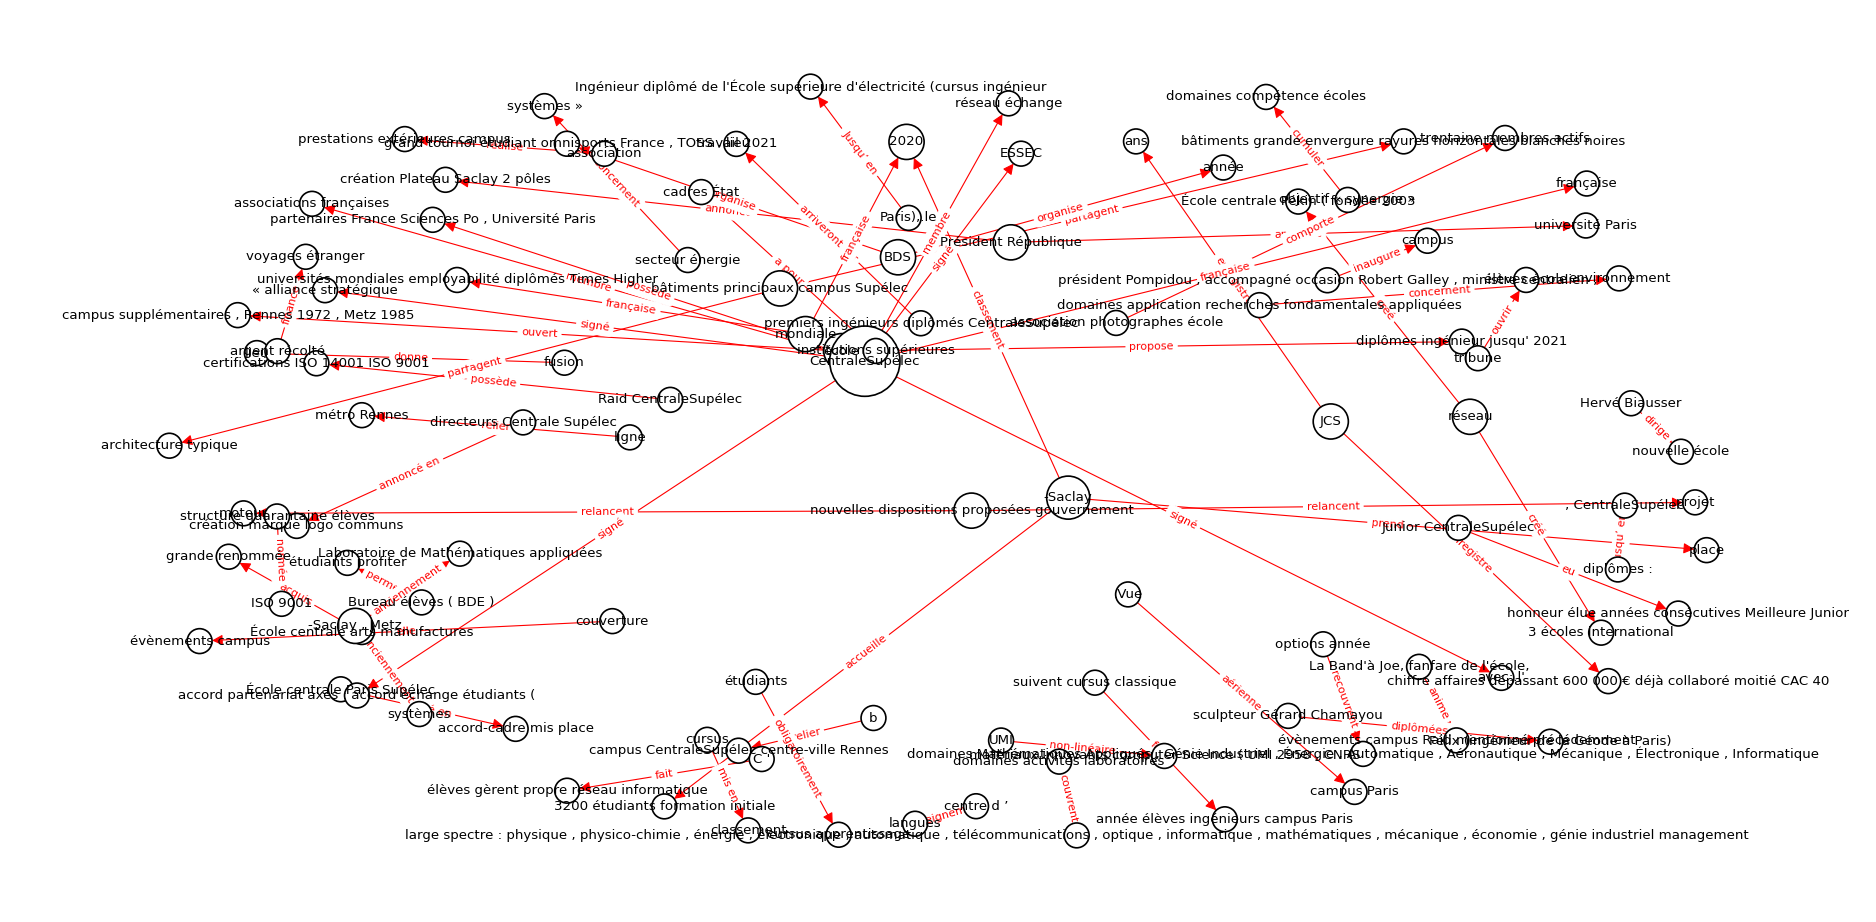

In [ ]:
draw_kg(relations_with_scrap)

# Dataset Creation

## Training set

In [12]:
dataset = pd.DataFrame(columns=['relation', 'label'])
dataset = relations_with_scrap[['relation', 'label']]
dataset.head()

NameError: ignored

In [ ]:
dataset.to_csv(path_or_buf='./relation_dataset.csv')

## Testing set

In [13]:
dataset_test = pd.DataFrame(columns=['relation', 'label'])
dataset_test = relations_for_test[['relation', 'label']]
dataset_test.head()

,relation,label
0,ville successivement centre monarchie romaine,1
1,-1455 perpétuent tradition architecture romaine,1
2,Rome fait principales destinations touristique...,1
3,Ville Éternelle une monde,1
4,siège papauté pèlerinage Rome font lieu éminent,1


In [14]:
dataset_test.to_csv(path_or_buf='./test_dataset.csv')